In [1]:
import pandas as pd
import numpy as np
import torch
import os
from PIL import Image
from io import BytesIO
import random
from zipfile import ZipFile

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.utils import shuffle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from DepthData_mob import DepthDataset
from DepthData_mob import Augmentation
from DepthData_mob import ToTensor

In [2]:
os.getcwd()

'/workspace'

In [27]:
from zipfile import ZipFile
zf = ZipFile('/workspace/FILENAME', 'r')
zf.extractall('/workspace/')
zf.close()

In [2]:
# traincsv = shuffle(traincsv, random_state=0)
traincsv=pd.read_csv('/workspace/data/nyu2_train.csv')
traincsv = traincsv.values.tolist()
traincsv = shuffle(traincsv, random_state=2)

0 (640, 480) (640, 480)
1 (640, 480) (640, 480)


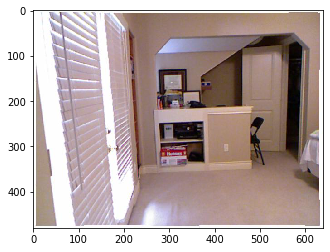

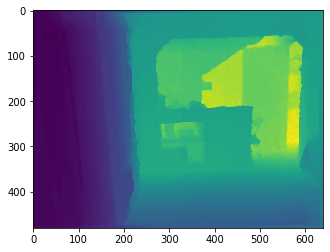

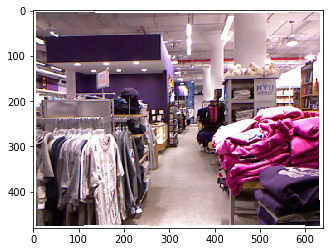

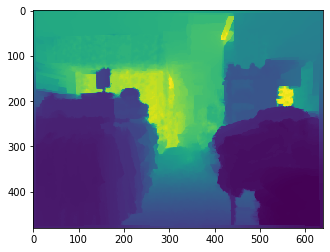

<Figure size 432x288 with 0 Axes>

In [3]:
depth_dataset = DepthDataset(traincsv=traincsv,
                                    root_dir='/workspace/')
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    print(i, sample['image'].size, sample['depth'].size)


    plt.imshow(sample['image'])
    plt.figure()
    plt.imshow(sample['depth'])
    plt.figure()


    if i == 1:
        plt.show()
        break

In [7]:
depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
depth_dataset

In [8]:
batch_size=4
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size, shuffle=True)
train_loader

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [10]:
images

'image'

In [ ]:
from model_dense import Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1280, decoder_width = .6):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=1)
        
        self.up0 = UpSample(skip_input=features//1 + 320, output_features=features//2)
        self.up1 = UpSample(skip_input=features//2 + 160, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 64, output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 32, output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 +  24, output_features=features//8)
        self.up5 = UpSample(skip_input=features//8 +  16, output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4,x_block5,x_block6 = features[2], features[4], features[6], features[9], features[15],features[18],features[19]
        x_d0 = self.conv2(x_block6)
        x_d1 = self.up0(x_d0, x_block5)
        x_d2 = self.up1(x_d1, x_block4)
        x_d3 = self.up2(x_d2, x_block3)
        x_d4 = self.up3(x_d3, x_block2)
        x_d5 = self.up4(x_d4, x_block1)
        x_d6 = self.up5(x_d5, x_block0)
        return self.conv3(x_d6)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        import torchvision.models as models
        self.original_model = models.mobilenet_v2( pretrained=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [25]:
epoch=999
model = Model().cuda()
path='/workspace/'+str(epoch)+'.pth'        
torch.save(model.state_dict(), path)

In [8]:
import torchvision.models as models
original_model = models.mobilenet_v2( pretrained=True )

AttributeError: module 'torchvision.models' has no attribute 'mobilenet_v2'

In [ ]:
pip install torch torchvision

In [12]:
# import torchvision.models as models
# original_model = models.resnet18 ( pretrained=True )
# original_model.layer1
# res50_model = models.resnet50(pretrained=True)
# res50_conv = nn.Sequential(*list(res50_model.children())[:-2])
# res50_conv[10]
# # for i,(k, v) in enumerate(original_model.features._modules.items()): 
# #     print(k,i+1)
# # for i,(k, v) in enumerate(original_model.items()): 
# #     print(k,i+1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100.0%
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
62.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

93.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
pip install tensorboardX


    100% |████████████████████████████████| 204kB 6.4MB/s ta 0:00:01
    100% |████████████████████████████████| 1.3MB 7.8MB/s ta 0:00:011
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install kornia

     |################################| 122kB 2.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import kornia 

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    ssim = kornia.losses.SSIM(window_size=11,max_val=val_range,reduction='none')
    return ssim(img1, img2)

In [5]:
import matplotlib
import matplotlib.cm
import numpy as np


def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin=10, vmax=1000, cmap='plasma'):
    value = value.cpu().numpy()[0,:,:]

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    #value = value.squeeze(axis=0)

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=True) # (nxmx4)

    img = value[:,:,:3]

    return img.transpose((2,0,1))

In [6]:
def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))
    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    output = DepthNorm( model(image) )
    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image('Train.3.Diff', colorize(vutils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    del image
    del depth
    del output
    

In [3]:
import torchvision.models as models
shufflenet = models.googlenet(pretrained=True)

AttributeError: module 'torchvision.models' has no attribute 'googlenet'

In [9]:
pip install tensorboardX

     |################################| 204kB 2.4MB/s eta 0:00:01
     |################################| 1.3MB 6.4MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch.hub
model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.4.2.zip" to /root/.torch/hub/v0.4.2.zip

FileNotFoundError: [Errno 2] No such file or directory: '/root/.torch/hub/vision-v0.4.2'

In [7]:
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
from tensorboardX import SummaryWriter

# from data import getTrainingTestingData
# from utils import AverageMeter, DepthNorm, colorize

model = Model().cuda()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

# model.load_state_dict(torch.load('/workspace/3.pth'))

#model = Model()
print('Model created.')


epochs=2
lr=0.0001
batch_size=64

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)
l1_criterion = nn.L1Loss()

optimizer = torch.optim.Adam( model.parameters(), lr )

# Start training...
for epoch in range(epochs):
    path='/workspace/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        #Prepare sample and target
        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm( depth )

        # Predict
        output = model(image)

        # Compute the loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)

        # Update step
       
        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log progress
        niter = epoch*N+i
        if i % 5 == 0:
            # Print to console
            print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
            'ETA {eta}\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})'
            .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))

            # Log to tensorboard
            #writer.add_scalar('Train/Loss', losses.val, niter)
            
    path='/workspace/'+str(epoch)+'.pth'        
    torch.save(model.state_dict(), path)    
#         if i % 300 == 0:
#             LogProgress(model, writer, test_loader, niter)

#     # Record epoch's intermediate results
#     LogProgress(model, writer, test_loader, niter)
#     writer.add_scalar('Train/Loss.avg', losses.avg, epoch)




Let's use 6 GPUs!
Model created.
Epoch: [0][0/792]	Time 20.492 (20.492)	ETA 4:30:29	Loss 0.6886 (0.6886)
Epoch: [0][5/792]	Time 1.731 (29.527)	ETA 0:22:41	Loss 0.7081 (0.7083)
Epoch: [0][10/792]	Time 1.754 (38.361)	ETA 0:22:51	Loss 0.8597 (0.7224)
Epoch: [0][15/792]	Time 1.747 (47.127)	ETA 0:22:37	Loss 0.7063 (0.7183)
Epoch: [0][20/792]	Time 1.799 (56.157)	ETA 0:23:09	Loss 0.6845 (0.7097)
Epoch: [0][25/792]	Time 1.812 (65.141)	ETA 0:23:09	Loss 0.6615 (0.6989)
Epoch: [0][30/792]	Time 1.773 (74.156)	ETA 0:22:31	Loss 0.6235 (0.6899)
Epoch: [0][35/792]	Time 1.799 (83.012)	ETA 0:22:42	Loss 0.6443 (0.6833)
Epoch: [0][40/792]	Time 1.776 (92.017)	ETA 0:22:15	Loss 0.6239 (0.6772)
Epoch: [0][45/792]	Time 1.822 (100.958)	ETA 0:22:41	Loss 0.6219 (0.6716)
Epoch: [0][50/792]	Time 1.757 (109.972)	ETA 0:21:43	Loss 0.6329 (0.6669)
Epoch: [0][55/792]	Time 1.751 (118.831)	ETA 0:21:30	Loss 0.6218 (0.6631)
Epoch: [0][60/792]	Time 1.801 (127.816)	ETA 0:21:58	Loss 0.6144 (0.6593)
Epoch: [0][65/792]	Time 1.78

KeyboardInterrupt: 

In [20]:
model = Model().cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('/workspace/3.pth'))
model.eval()


DataParallel(
  (module): Model(
    (encoder): Encoder(
      (original_model): DenseNet(
        (features): Sequential(
          (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu0): ReLU(inplace=True)
          (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (denseblock1): _DenseBlock(
            (denselayer1): _DenseLayer(
              (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu1): ReLU(inplace=True)
              (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu2): ReLU(inplace=True)
              (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [32]:
batch_size=1

depth_dataset = DepthDataset(traincsv=traincsv, root_dir='/workspace/',
                transform=transforms.Compose([Augmentation(0.5),ToTensor()]))
train_loader=DataLoader(depth_dataset, batch_size, shuffle=True)

for sample_batched1  in (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    outtt=model(image1 )
    break

    

In [33]:
x=outtt.detach().cpu().numpy()

In [34]:
x.shape
x=x.reshape(240,320)


In [35]:
x.shape

(240, 320)

In [36]:
torch.cuda.empty_cache()

In [37]:
sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0).shape

(480, 640, 3)

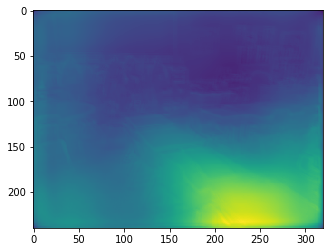

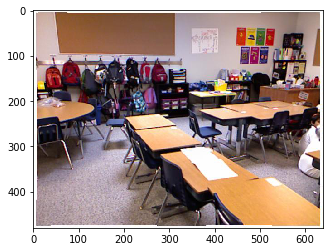

In [38]:
plt.imshow(x)
plt.figure()
plt.imshow(sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0))